In [1]:
# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 98):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98

# Fig1

In [67]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
#df = df.loc[df['age'] < 10]
print(f'초기 전체 opid: {len(df)}')
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

print(f'airway tube type이 plain이 아닌 경우 제외: {len(df)}')
# age, sex, airway tube size 값이 없는 경우는 제외

df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'age, airway_tube_size 결측치 제외: {len(df)}')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')
#df3 = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='left', on='opid')

# inclusion criteria : 소아 10세 미만
#df['age_cal'] = df['age_cal'] + 0.01 # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
len(df)

695913
282792
281976


59352

In [64]:
df[df['opid']==140924126]

,opid,sex,age,airway_tube_size,airway_tube_type,airway_lma,weight,height,age_cal,opdate,birth_date
47551,140924126,False,10,6.5,plain,NaN,56.1,154.2,9.998836,2014-09-24,2004-09-24


In [32]:
# age와 age_cal 값이 차이나는 데이터들
set1 = set(df.loc[df['age'] < 10]['opid'].values)
set2 = set(df.loc[df['age_cal'] < 10]['opid'].values)
set2 - set1

{60119113,
 100402123,
 120215116,
 140924126,
 200731100,
 200929098,
 201222093,
 210107143,
 210108148,
 210111133,
 210111166,
 210113141,
 210113147,
 210115136,
 210118133,
 210118134,
 210121144,
 210121162,
 210122155,
 210122169,
 210125128,
 210128129,
 210201134,
 210201140,
 210203163,
 210205152,
 210209131,
 210209140,
 210210139,
 210212003,
 210217139,
 210223142,
 210224134,
 210224142,
 210225129,
 210303159,
 210304151,
 210304152,
 210308151,
 210308152,
 210308154,
 210308155,
 210309133,
 210312153,
 210315129,
 210315131,
 210315133,
 210315153,
 210318127,
 210319122,
 210322127,
 210322150,
 210322151,
 210324140,
 210324145,
 210325147,
 210326126,
 210329134,
 210331129,
 210401156,
 210406134,
 210407127,
 210407134,
 210408134,
 210409136,
 210419123,
 210419145,
 210419149,
 210426126,
 210427139,
 210428125,
 210429136,
 210503124,
 210503147,
 210504133,
 210506126,
 210510140,
 210512146,
 210514150,
 210517123,
 210520141,
 210524127,
 210524128,
 2105

In [73]:
# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')

cuffed data가 없는 경우는 제외: 45067


In [77]:
# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

중복되는 hid는 첫번째 수술 외 제외: 34042


# Data preprocessing

In [79]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

# age, sex, airway tube size 값이 없는 경우는 제외
df.dropna(subset=['age', 'airway_tube_size'], inplace=True)
df['sex'] = (df['sex'] == 'M')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')


# inclusion criteria : 소아 10세 미만
df = df.loc[df['age_cal'] < 10-0.01]
df = df.loc[df['age_cal'] > 0]

In [80]:
# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')


perc = np.mean(df['cuffed'].values)
print(f'소아 10세 미만에서 cuffed ETT 사용 비율: {perc:.3f}')
print(f'소아 10세 미만 최종 opid수: {len(df)}')

중복되는 hid는 첫번째 수술 외 제외: 34042
소아 10세 미만에서 cuffed ETT 사용 비율: 0.287
소아 10세 미만 최종 opid수: 34042


In [171]:
# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

In [85]:
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed']
TARGET_VAR = 'airway_tube_size'

random.seed(SEED)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
c = df['opid'].values.flatten().astype(int)
#y_old = df[[OLD_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)

# 저장하기
#np.savez(f'dataset/ETT_size.npz', x=x, y=y, y_old=y_old, c=c)

In [88]:
#dat = np.load(f'dataset/ETT_size.npz')

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


In [ ]:
# label encoding for classification model: 2 -> 0, 2.5 -> 1, ... 8.5 -> 14 로 tube size x 2 - 4
df['label'] = df[TARGET_VAR].apply(lambda x: x*2-4)

for i in range(14):
    df[f'{i}'] = df['label'].apply(lambda x: 1 if x==i else 0)
    
y_label = df[[f'{i}' for i in range(14)]].values
yl_test = y_label[-ntest:]
yl_train = y_label[:ntrain]

# ETT Size

## age-based formula

In [ ]:
# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y[-ntest:]

In [192]:
print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.777
mean_squared_errors: 0.297
r2_score: 0.695
acc: 0.339
acc(+-0.5mm): 0.868


## XGBoostRegression

* 결측치 그대로 이용

In [193]:
# age 
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [4, 5, 7],#[3,4,5],
                'n_estimators': [100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = RandomizedSearchCV(n_iter=100,
                        estimator=xgb.sklearn.XGBRegressor(),
                        n_jobs=-1,
                        verbose=5,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2

print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/painstudy/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



========= found hyperparameter =========
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'colsample_bytree': 0.5}
0.8717466516356295
--------------
old model = age/4+4
--------------
explained_variance_score: 0.777
mean_squared_errors: 0.297
r2_score: 0.695
acc: 0.339
acc(+-0.5mm): 0.868
--------------
new model
--------------
explained_variance_score: 0.855
mean_squared_errors: 0.141
r2_score: 0.855
acc: 0.587
acc(+-0.5mm): 0.963
[CV 3/5] END colsample_bytree=0.5, max_depth=4, n_estimators=100, subsample=0.5;, score=0.871 total time=   1.9s
[CV 2/5] END colsample_bytree=0.5, max_depth=5, n_estimators=200, subsample=0.8;, score=0.866 total time=   3.5s
[CV 4/5] END colsample_bytree=0.5, max_depth=7, n_estimators=300, subsample=0.8;, score=0.857 total time=   7.1s
[CV 5/5] END colsample_bytree=0.8, max_depth=7, n_estimators=100, subsample=0.8;, score=0.868 total time=   3.8s
[CV 1/5] END colsample_bytree=0.5, max_depth=5, n_estimators=200, subsample=0.5;, score=0.865 total time

* 결측치 multi-imputer로 채운 경우

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [78]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [4, 5, 7],#[3,4,5],
                'n_estimators': [100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = RandomizedSearchCV(n_iter=100,
                        estimator=xgb.sklearn.XGBRegressor(),
                        n_jobs=-1,
                        verbose=3,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/painstudy/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



========= found hyperparameter =========
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'colsample_bytree': 0.8}
0.871740670673633
--------------
new model
--------------
explained_variance_score: 0.857
mean_squared_errors: 0.140
r2_score: 0.857
acc: 0.590
acc(+-0.5mm): 0.964


### cuffed model

In [ ]:
train_mask = (x_train[:,4] == 1)
test_mask = (x_test[:,4] == 1)

x_train_c = x_train[train_mask,0:4]
y_train_c = y_train[train_mask,0:4]

### plotting

In [197]:
xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        cvals.append(sum((y_pred == x) & (y_test == y)))
        cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals_old, label='4+AGE/4')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.plot([2.5,8], [2,7.5], '--k', alpha=0.1)
plt.plot([2,7.5], [2.5,8], '--k', alpha=0.1)
plt.savefig('old_tube-size.png')
plt.close()

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='blue', alpha=0.5, s=cvals, label='XGBR')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.plot([2.5,8], [2,7.5], '--k', alpha=0.1)
plt.plot([2,7.5], [2.5,8], '--k', alpha=0.1)
plt.savefig('xgbr_tube-size.png')
plt.close()

In [ ]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'regression model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

## RandomForest

In [76]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [81]:
from sklearn.ensemble import RandomForestRegressor

SEED = 0
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [4, 5, 7],#[3,4,5],
                'n_estimators': [100, 200, 300],
                'max_features': ['auto', 'sqrt', 'log2'],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'min_samples_split': [2,3,5],
                'min_samples_leaf': [1,2,3],
               'bootstrap': [True, False]
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = GridSearchCV(n_iter=500,
                        estimator=RandomForestRegressor(random_state = SEED),
                        n_jobs=-1,
                        verbose=5,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

Fitting 5 folds for each of 100 candidates, totalling 500 fits

========= found hyperparameter =========
{'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': True}
0.8732191690919636


In [83]:
rfr = RandomForestRegressor(random_state=SEED,  n_estimators= 300, min_samples_split= 3, min_samples_leaf= 1, max_features='sqrt', max_depth= 7, bootstrap= True)
rfr.fit(x_train_imputed, y_train)
y_pred = rfr.predict(x_test_imputed).flatten()

y_pred = np.round(y_pred * 2) / 2

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
new model
--------------
explained_variance_score: 0.859
mean_squared_errors: 0.139
r2_score: 0.858
acc: 0.586
acc(+-0.5mm): 0.966


## SVM

In [101]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


SEED = 98
param_grid = {'C': [1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf','linear']} 

nfold = 4
gs = GridSearchCV(estimator=SVR(),
                  n_jobs=-1,
                  refit=True,
                  verbose=3,
                  param_grid=param_grid, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")


y_pred = gs.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 4 folds for each of 32 candidates, totalling 128 fits


## ANN

In [84]:
from keras import losses, metrics
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, interp
import os, sys, pickle, shutil
import pandas as pd
import numpy as np
import random, datetime, time
from sklearn.model_selection import KFold


# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 98):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [105]:
x_train.shape

(35971, 5)

In [104]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(df.loc[:ntrain-1,INPUT_VARS])
x_test = sc.transform(df.loc[ntrain:,INPUT_VARS])

In [106]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [88]:
# save model
#odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_{nfold}fold'
odir_f = f'DNN_size'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)

In [115]:
dense_node = 512
dropout = 0.3
batch_size = 64
learning_rate = 0.001

# model
inp = Input(shape=(x_train.shape[1],))
out = inp

out = Dense(dense_node, activation='relu')(out)
out = BatchNormalization()(out)
out = Dropout(dropout)(out)
out = Dense(dense_node, activation='relu')(out)
out = Dropout(dropout)(out)
out = Dense(1, activation=None)(out)

model = Model(inputs=[inp], outputs=[out])
#model.save_weights(f'{odir}/initial_weights.hdf5')

weightcache = f"{odir}/weights.hdf5"
model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=["mean_absolute_error"])
hist = model.fit(x_train_imputed, y_train, validation_split=0.2, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                        callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                    EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])

model.load_weights(weightcache)
y_pred = model.predict(x_test_imputed).flatten()

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
449/450 [============================>.] - ETA: 0s - loss: 0.9451 - mean_absolute_error: 0.5390
Epoch 00001: val_loss improved from inf to 0.63609, saving model to result/DNN_size/weights.hdf5
450/450 [==============================] - 3s 5ms/step - loss: 0.9441 - mean_absolute_error: 0.5388 - val_loss: 0.6361 - val_mean_absolute_error: 0.2973
Epoch 2/100
444/450 [============================>.] - ETA: 0s - loss: 0.3555 - mean_absolute_error: 0.4044
Epoch 00002: val_loss improved from 0.63609 to 0.27092, saving model to result/DNN_size/weights.hdf5
450/450 [==============================] - 2s 5ms/step - loss: 0.3538 - mean_absolute_error: 0.4039 - val_loss: 0.2709 - val_mean_absolute_error: 0.2828
Epoch 3/100
445/450 [============================>.] - ETA: 0s - loss: 0.2866 - mean_absolute_error: 0.3900
Epoch 00003: val_loss improved from 0.27092 to 0.17374, saving model to result/DNN_size/weights.hdf5
450/450 [==============================] - 2s 4ms/step - loss: 0.2860 -

In [116]:
y_pred = model.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2

print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
print(f'acc: {np.mean(y_pred==y_test):.3f}')
print(f'acc(+-0.5mm): {np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5)):.3f}')

explained_variance_score: 0.843
mean_squared_errors: 0.153
r2_score: 0.840
acc: 0.567
acc(+-0.5mm): 0.955


# Insertion depth

In [126]:
df.isnull().sum()

opid                    0
sex                     0
age                     0
weight_o                6
height_o              373
airway_tube_size        0
airway_tube_type        0
airway_lma          44938
weight                645
height               1310
age_cal                 0
opdate                  0
birth_date              0
fixed                4638
cuffed                  0
old_tube_size           0
label                   0
0                       0
1                       0
2                       0
3                       0
4                       0
5                       0
6                       0
7                       0
8                       0
9                       0
10                      0
11                      0
12                      0
13                      0
dtype: int64

In [198]:
dff = df.dropna(subset=['fixed'])
depths = dff['fixed'].values

In [201]:
min(depths), max(depths)

(0.0, 24.0)

(array([7.0000e+00, 4.5000e+01, 2.5100e+02, 2.2040e+03, 6.8630e+03,
        1.4196e+04, 1.0387e+04, 5.9750e+03, 3.6700e+02, 3.0000e+01]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

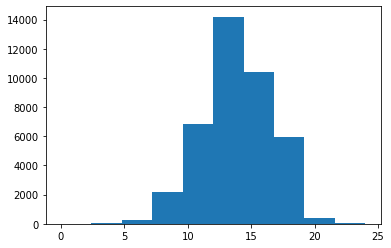

In [199]:
plt.hist(depths)

In [137]:
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed', 'airway_tube_size']
TARGET_VAR = 'fixed'

seed_everything(SEED)
df.dropna(subset=['fixed'], inplace=True)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

## PALS guideline

In [145]:
OLD_VAR = 'old_depth1'
# OLD_VAR = 'old_tube_size'
df[OLD_VAR] = 3 * df['airway_tube_size']
#df[OLD_VAR] = df['airway_tube_size'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
#df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

print('--------------')
print('old model = 3 * ETT size')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')

--------------
old model = 3 * ETT size
--------------
explained_variance_score: 0.603
mean_squared_errors: 3.097
r2_score: 0.569


In [144]:
OLD_VAR = 'old_depth1'
# OLD_VAR = 'old_tube_size'
df[OLD_VAR] = 3 * df['old_tube_size']
#df[OLD_VAR] = df['airway_tube_size'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
#df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

print('--------------')
print('old model = 3 * age-based ETT size')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')

--------------
old model = 3 * age-based ETT size
--------------
explained_variance_score: 0.624
mean_squared_errors: 2.808
r2_score: 0.609


In [143]:
OLD_VAR = 'old_depth1'
# OLD_VAR = 'old_tube_size'
df[OLD_VAR] = df['age'] / 2 + 12
#df[OLD_VAR] = df['airway_tube_size'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
#df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

print('--------------')
print('old model = age / 2 + 12')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')

--------------
old model = age / 2 + 12
--------------
explained_variance_score: 0.592
mean_squared_errors: 2.977
r2_score: 0.585


In [131]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [4, 5, 7],#[3,4,5],
                'n_estimators': [100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = RandomizedSearchCV(n_iter=100,
                        estimator=xgb.sklearn.XGBRegressor(),
                        n_jobs=-1,
                        verbose=5,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')

/home/painstudy/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 36 candidates, totalling 180 fits

========= found hyperparameter =========
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'colsample_bytree': 0.5}
0.7925042013962639
--------------
new model
--------------
explained_variance_score: 0.790
mean_squared_errors: 1.561
r2_score: 0.790


In [133]:
print(f'acc(+-1cm): {np.mean((y_pred >= y_test-1) & (y_pred <= y_test+1)):.3f}')

acc(+-1cm): 0.700


In [134]:
np.min(y_pred), np.max(y_pred), np.min(y_test), np.max(y_test)

(7.589564, 20.347792, 1.5, 24.0)

In [ ]:
plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='blue', alpha=0.5, s=cvals, label='GBRT')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.savefig('new.png')
plt.close()